# lorapy data processing

In [1]:
%load_ext autoreload
%autoreload 2

import pathlib

import os, sys
from loguru import logger
logger.remove(None)
logger.add(sys.stdout, colorize=True)

import numpy as np

import matplotlib.pyplot as plt 
plt.style.use('dark_background')
%matplotlib inline

In [2]:
import lorapy

## setup 

In [3]:
_BASE_DATA_DIR = pathlib.Path('/Users/trevor/Work/1-projects/lora-processing/data')

BENCHTOP_DATA_DIR = _BASE_DATA_DIR.joinpath('lora-benchtop-recording')
OTA_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_OTA')
OUTDOOR_DATA_DIR = _BASE_DATA_DIR.joinpath('LoRa_Recording_Outdoor')
DOTP_DATA_DIR = _BASE_DATA_DIR.joinpath('symbol-ref')

## utils

In [4]:
import random
rand = lambda mx: random.randint(0, mx)

# load

## dat files

In [5]:
loader = lorapy.load_dat(BENCHTOP_DATA_DIR, autoload=True)
loader.filter(bw=9, sf=10)

2020-04-08 12:53:49.294 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/lora-benchtop-recording
2020-04-08 12:53:49.302 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 110 data file(s)


[DatFile(id=89 | name='lora_BW9_SF10_915MHz_20ksps_Att60_v0.dat'),
 DatFile(id=94 | name='lora_BW9_SF10_915MHz_20ksps_Att120_v0.dat'),
 DatFile(id=96 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.dat'),
 DatFile(id=97 | name='lora_BW9_SF10_915MHz_20ksps_Att100_v0.dat'),
 DatFile(id=100 | name='lora_BW9_SF10_915MHz_20ksps_Att40_v0.dat'),
 DatFile(id=101 | name='lora_BW9_SF10_915MHz_20ksps_Att80_v0.dat'),
 DatFile(id=107 | name='lora_BW9_SF10_915MHz_20ksps_Att20_v0.dat')]

In [6]:
file = loader.select(96)
file

DatFile(id=96 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.dat')

## dotp files

In [7]:
ploader = lorapy.load_dotp(DOTP_DATA_DIR)
ploader.filter(bw=9, sf=10)

2020-04-08 12:53:49.386 | DEBUG    | lorapy.io._base_loader:_validate_data_path:140 - set datafile directory: /Users/trevor/Work/1-projects/lora-processing/data/symbol-ref
2020-04-08 12:53:49.390 | INFO     | lorapy.io._base_loader:_process_data_dir:153 - found 15 data file(s)


[DotPFile(id=1 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p')]

In [8]:
pfile = ploader.select(1)
pfile

DotPFile(id=1 | name='lora_BW9_SF10_915MHz_20ksps_Att0_v0.p')

# process

## convert 

In [9]:
signal = file.to_signal()
signal

2020-04-08 12:53:49.469 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-08 12:53:49.540 | INFO     | lorapy.datafile._base_file:load:61 - loaded 15036416 samples from file


LoraSignal(length=15036416) | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100

In [10]:
base_symbol = pfile.to_signal()
base_symbol

2020-04-08 12:53:49.572 | DEBUG    | lorapy.datafile.encoding:compute_params:15 - computed samples per symbol: 400 and packet length: 12100
2020-04-08 12:53:49.574 | INFO     | lorapy.datafile._base_file:load:61 - loaded 399 samples from file


BaselineSymbolSet(num symbols=399 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100)

## stats 

In [11]:
signal.stats

BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100

In [12]:
base_symbol.stats

BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100

## plots

/Users/trevor/miniconda3/envs/py37-prime/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


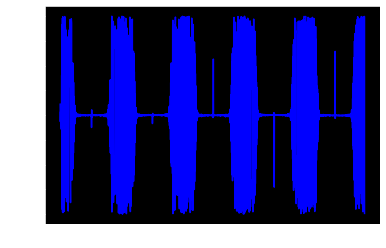

In [13]:
signal.plot(real=False, stop=2_000, color='blue')

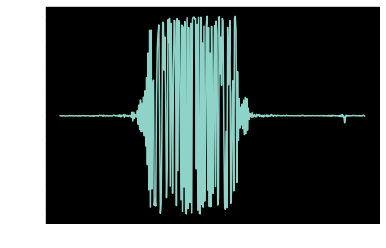

In [14]:
plt.plot(base_symbol.data)

# packets

## extract - auto adjust

## extract - manual adjust

In [15]:
signal.extract_packets(method='slide-mean', auto_adj=False, overlap=0.7)

2020-04-08 12:53:50.102 | INFO     | lorapy.signals.signal:_process_signal:107 - selected "slide-mean" processing method
2020-04-08 12:53:50.149 | INFO     | lorapy.signals.processing.sliding_mean:_find_all_mindices:55 - scanning signal for padding locations..
2020-04-08 12:53:50.150 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 0
2020-04-08 12:53:50.177 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 100
2020-04-08 12:53:50.197 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 200
2020-04-08 12:53:50.215 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 300
2020-04-08 12:53:50.233 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 400
2020-04-08 12:53:50.252 | DEBUG    | lorapy.signals.processing.sliding_mean:_find_all_mindices:59 - iteration 500
2020-04-08 12:53:50.266 | DEBUG    | lorapy.signals.proce

In [ ]:
signal.adjust_packets(force_check=True, baseline_symbol=base_symbol, range_factor=10, step=2, scalar=0.6)

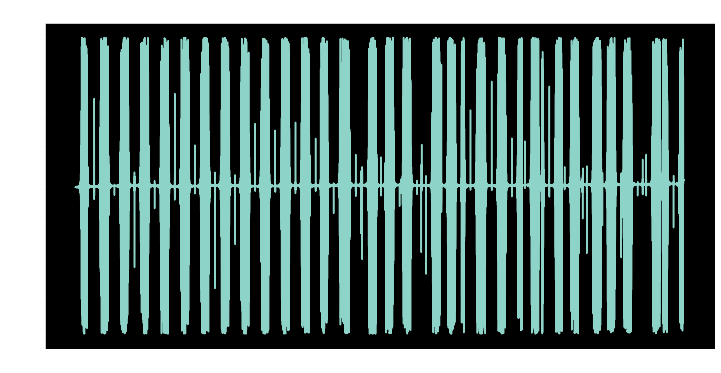

In [34]:
plt.figure(figsize=(12,6))
signal.plot_packet()

In [ ]:
packet = signal.packets[1090]
packet

In [ ]:
plt.figure(figsize=(15,6))
packet.plot(real=False)

## inspect

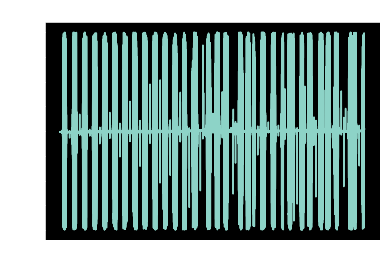

LoraPacket(id=778) || size: 12100 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100

In [37]:
packet = signal.random_packet
packet.plot()
display(packet) 

# symbols

In [38]:
packet

LoraPacket(id=778) || size: 12100 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100

## extraction

In [39]:
packet.extract_preamble_symbols()

2020-04-08 13:10:13.373 | DEBUG    | lorapy.symbols.utils:slice_preamble_symbols:27 - extracted 8 symbols with length 400
2020-04-08 13:10:13.374 | DEBUG    | lorapy.packets.packet:_slice_and_load:155 - loaded 8 lora symbols


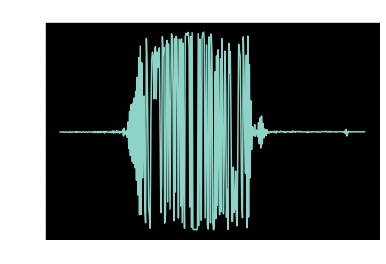

In [63]:
packet.plot_symbol()

In [67]:
packet._raw_symbols

(8, 400)

## inspection

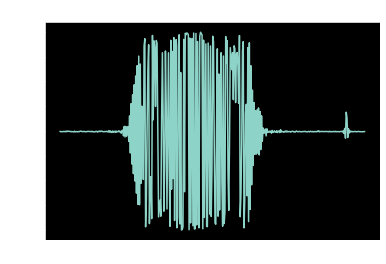

LoraSymbol(id=4) || size: 400 | BW: 9 | SF: 10 | Att: 0 | samples per symbol: 400 | packet length: 12100

In [51]:
symbol = packet.random_symbol
symbol.plot()
display(symbol) 

## convolution

## convolve

In [52]:
symbol.convolve(base_symbol)

2020-04-08 13:11:00.098 | DEBUG    | lorapy.symbols.symbol:convolve:37 - convolved symbol with baseline: 0.20910901312530425


0.20910901312530425

/Users/trevor/miniconda3/envs/py37-prime/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


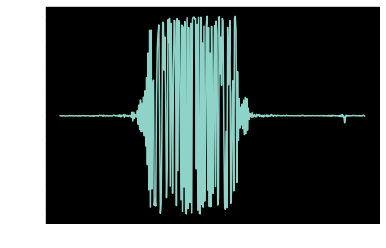

In [55]:
plt.plot(base_symbol.data)

## signal all together

In [ ]:
packet = signal.random_packet
packet.extract_preamble_symbols()

packet.plot()
display(packet)

In [ ]:
symbol = packet.random_symbol
symbol.plot()
display(symbol) 

In [ ]:
symbol.convolve(baseline[562])

In [ ]:
symbol.absolute_endpoints

In [ ]:
signal.plot(real=False, start=symbol.absolute_endpoints[0], stop=symbol.absolute_endpoints[1])

In [ ]:
signal.stats.filename

## conv scratch

In [ ]:
baseline = baseline[0:signal.stats.samp_per_sym]

c_out = []

for i in range(symbols.shape[0]):
    sig = symbols[i,:]
    sig_c = np.conj(sig[::-1])
    conv_val = np.abs(np.convolve(baseline,sig_c))/np.linalg.norm(sig)/np.linalg.norm(sig)

    c_out.append(np.max(conv_val))

fig = plt.figure(figsize=(15,5))
plt.plot(c_out)